# Data Cleaning for Uncommon

## Deliverable
### The final sheet will have the following:
1) Student Number  
2) Score  
3) Subject  
4) High School  
5) Graduating cohort year  
- If a student was in 12th grade in 2017-18, they are in the graduating cohort of 2018  
  
6) A flag indicating if the student passed the exam
- An AP exam score of 3, 4, or 5 is considered passing  
  
7) Demographic information on each student/exam combination including:  
- FRPL (Free or Reduced Price Lunch) status  
- Ethnicity  
- Gender
  
8) Teacher Name

## Key Takeaways
### Data Integretity
- The AP Results sheet had a number of duplicate values (multiple rows of a student-test pair), with two instances of students having varied scores for the same test.
- The Teacher sheet was missing a teacher for English Lang & Composition at UCHS.
- The student sheet included one student classified as 'Z' for Ethnicity (assuming this is an error).

The solution for cleaning these would be to 1). Better understand the query that pulled in the score data and remove duplicates at the top 2). Update the data source for teacher-subject pairings 3). Consider a dropdown menu for data entry in the student information system for fields like Ethnicity that should be normalized.

### Summary - See additional Data Viz at the bottom
- Of the 5 High Schools in this data, 3 had students take AP tests in 2018.
- 10th, 11th, and 12th graders took AP tests
- We end with information about 639 tests taken.
- NSA-HS had the highest passing rate (around 61%) and UCHS had the lowest (around 40%).
- There is a healthy mix of courses taken, but there seems to be a trend that AP courses with lower participation rates have higher passing rates.
- Not FRPL students had a slightly higher passing rate than FRPL students, a difference of 3.2%.

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Read in the provided data sheets
xls = pd.ExcelFile('Data_Preparation_Exercise.xlsx')
df_ap = pd.read_excel(xls, 'AP Results')
df_teacher = pd.read_excel(xls, 'Teacher')
df_student = pd.read_excel(xls, 'Student Roster')

In [3]:
#Inspect value counts across the data and inspect for potential errors
x = [df_ap, df_student, df_teacher]

for i in x:
    for j in i.columns:
        print(i[j].value_counts())

303000108    7
301001368    7
301001142    7
301001066    7
301001058    7
            ..
301001253    1
268258852    1
301001251    1
301001250    1
401000005    1
Name: Student Number, Length: 334, dtype: int64
2    267
3    229
1    101
4     92
5     31
Name: Score, dtype: int64
World History                   244
US History                      157
Biology                          96
English Lit and Composition      51
English Lang and Composition     35
Calc AB                          33
Environmental Science            27
Calc BC                          24
US Gov and Politics              20
Chemistry                        19
Computer Science A               14
Name: Subject, dtype: int64
9th Grade     507
10th Grade    258
11th Grade    211
12th Grade    134
Name: Grade, dtype: int64
NSA-HS    410
UCHS      398
UCC       185
UPC        78
TNRPHS     39
Name: School, dtype: int64
205174782    1
205376163    1
301001369    1
214190746    1
301001260    1
            ..
2073982

#### Initial Takeaways

AP
- Multiple instances of students taking more than one test - tests taken max is 7, min is 1. Still want to double check student subject duplicates.
- Mostly 2's and 3's for score.
- Don't appear to be any naming mismatches in tests.

Student
- Roster is heavy on 9th graders, likely due to grade growth at the smaller schools (UPC and TNRPHS) but would want to clarify.
- No duplicate student Ids.
- One student classified as Z for Ethnicity - will drop.
- Assuming that coding for Lunch Status is - Free(F), Reduced(R), Paid in full(P), Free Direct Certified(FDC) - F, R, & FDC will class as FRPL.

Teacher
- No teachers at UPC and TNRPHS signifies there are no AP courses taught there.
- No duplicate teachers.
- No naming mismatch in courses.

In [4]:
#Checking for null values, inspecting data types
for i in x:
    print(i.info())
    print('//')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 3 columns):
Student Number    720 non-null int64
Score             720 non-null int64
Subject           720 non-null object
dtypes: int64(2), object(1)
memory usage: 17.0+ KB
None
//
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 6 columns):
Grade           1110 non-null object
School          1110 non-null object
Student ID      1110 non-null int64
Gender          1110 non-null object
Ethnicity       1110 non-null object
Lunch Status    1110 non-null object
dtypes: int64(1), object(5)
memory usage: 52.2+ KB
None
//
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
Subject    18 non-null object
School     18 non-null object
Teacher    18 non-null object
dtypes: object(3)
memory usage: 560.0+ bytes
None
//


This is a double check there are no null values - there are not. Having already inspected the values, we know there are no outliers and can begin to manipulate the data.

### Data cleaning

In [5]:
#The number of APs that some students had (7) seemed high for one year - let's c
#heck for duplicate rows (same subject, student id, and score) in the AP table
df_ap['check'] = df_ap['Student Number'].astype('str') + df_ap['Subject']
df_ap.check.value_counts()

205192396Biology                         3
274858554US History                      2
274858554Biology                         2
204010599Environmental Science           2
200052033Environmental Science           2
                                        ..
303000023English Lang and Composition    1
203108428World History                   1
301001198World History                   1
306001140US History                      1
205810427US History                      1
Name: check, Length: 639, dtype: int64

In [6]:
#This function will see if all values in a row are duplicated in another row - we drop 
#79 instances of duplicated values
print(len(df_ap))
df_ap = df_ap.drop_duplicates()
len(df_ap)

720


641

In [7]:
#Run a final check for duplicates in our check column
df_ap.check.value_counts()

206316473World History                   2
204899629World History                   2
204872006World History                   1
203061916US History                      1
202996872Calc AB                         1
                                        ..
206026312English Lang and Composition    1
401000041English Lit and Composition     1
205004575US History                      1
301001086World History                   1
205810427US History                      1
Name: check, Length: 639, dtype: int64

There are still two students with duplicate subjects, however these seem to have different scores for the same test. Let's inspect that:

In [8]:
#Inspect the two students with duplicate test names
df_ap[(df_ap['Student Number'] == 206316473) | (df_ap['Student Number'] == 204899629)]

,Student Number,Score,Subject,check
381,204899629,1,World History,204899629World History
429,206316473,2,World History,206316473World History
579,204899629,2,World History,204899629World History
606,206316473,1,World History,206316473World History


In [9]:
#I am dropping the lower score, giving students the benefit of the doubt for this exercise.
df_ap = df_ap.drop([381, 606])

### Data Engineering

In [10]:
#First, merge the df_student dataframe to the df_ap dataframe. This is a left Join, 
#keeping all students who have AP score data and dropping those who had no test data. 
#Join on Student ID/Student Number

scores = df_ap.merge(df_student, how='left', left_on='Student Number', right_on='Student ID')

In [11]:
#Generate a merge key to join the df_teacher table to scores on. Do this by concatenating 
#school and subject
df_teacher['teachkey'] = df_teacher['Subject']+df_teacher['School']

#Need to double check the key is unique and there are not multiple teachers per the same 
#AP subject at each school
df_teacher['teachkey'].value_counts()

Environmental ScienceUCHS             1
US Gov and PoliticsUCHS               1
Calc ABNSA-HS                         1
Calc BCNSA-HS                         1
BiologyUCHS                           1
BiologyUCC                            1
English Lang and CompositionNSA-HS    1
Computer Science ANSA-HS              1
BiologyNSA-HS                         1
US HistoryUCC                         1
World HistoryUCC                      1
World HistoryNSA-HS                   1
US HistoryNSA-HS                      1
Calc ABUCHS                           1
World HistoryUCHS                     1
US HistoryUCHS                        1
English Lit and CompositionNSA-HS     1
ChemistryNSA-HS                       1
Name: teachkey, dtype: int64

In [12]:
#There aren't, so I'm okay to generate a similar key for the scores table and join 
#teacher name on that key
scores['teachkey'] = scores['Subject']+scores['School']

#Merge teacher information from df_teacher
scores = scores.merge(df_teacher, how='left', on='teachkey')

In [13]:
#Generate fields for Graduating cohort year, FRPL status, and passing using basic conditionals

scores['Graduating'] = ['2018' if i == '12th Grade' else '2019' if i == '11th Grade' else '2020' 
                        if i == '10th Grade' else '2021' for i in scores['Grade']]

scores['FRPL'] = ['Not FRPL' if i == 'P' else 'FRPL' for i in scores['Lunch Status']]

scores['Passing'] = ['Passing' if i > 2 else 'Did not pass' for i in scores['Score']]

In [14]:
#Print column names to restructure the table for final output 
scores.columns

Index(['Student Number', 'Score', 'Subject_x', 'check', 'Grade', 'School_x',
       'Student ID', 'Gender', 'Ethnicity', 'Lunch Status', 'teachkey',
       'Subject_y', 'School_y', 'Teacher', 'Graduating', 'FRPL', 'Passing'],
      dtype='object')

In [15]:
#Restructure and rename the fields
scores = scores[['Student Number', 'Score', 'Subject_x', 'School_x', 'Graduating', 
                 'Passing', 'FRPL', 'Ethnicity', 'Gender', 'Teacher']]

scores = scores.rename(columns={"Subject_x": "Subject", "School_x": "High School", 
                                "Graduating": "Grad cohort year"})

#Sort the dataframe by Student Number to group student scores
scores = scores.sort_values('Student Number')

In [16]:
#Preview the final table
scores

,Student Number,Score,Subject,High School,Grad cohort year,Passing,FRPL,Ethnicity,Gender,Teacher
9,142021427,3,Biology,NSA-HS,2018,Passing,Not FRPL,Black,F,Smith
608,142021427,1,World History,NSA-HS,2018,Did not pass,Not FRPL,Black,F,Maestas
255,142021427,4,US History,NSA-HS,2018,Passing,Not FRPL,Black,F,Peiser
75,142021427,1,Calc AB,NSA-HS,2018,Did not pass,Not FRPL,Black,F,Ramirez
237,200051324,4,US Gov and Politics,UCHS,2018,Passing,FRPL,Black,F,Amos
...,...,...,...,...,...,...,...,...,...,...
131,700000041,3,Chemistry,NSA-HS,2019,Passing,FRPL,Black,F,Harris
204,700000043,3,English Lit and Composition,NSA-HS,2019,Passing,Not FRPL,Black,F,Herrera
561,700000043,3,World History,NSA-HS,2019,Passing,Not FRPL,Black,F,Maestas
136,700000058,2,Chemistry,NSA-HS,2019,Did not pass,FRPL,Black,M,Harris


### Final Inspection

In [17]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 9 to 351
Data columns (total 10 columns):
Student Number      639 non-null int64
Score               639 non-null int64
Subject             639 non-null object
High School         639 non-null object
Grad cohort year    639 non-null object
Passing             639 non-null object
FRPL                639 non-null object
Ethnicity           639 non-null object
Gender              639 non-null object
Teacher             626 non-null object
dtypes: int64(2), object(8)
memory usage: 54.9+ KB


We see there are null values in the Teacher column - it looks like there was no teacher listed for English Lang and Composition at UCHS. For now, I am keeping this data, assuming the data can easily be filled into the Teacher table prior to an upload and knowing that score information is more important than the one column with missing values.

In [18]:
scores[scores['Teacher'].isna()]

,Student Number,Score,Subject,High School,Grad cohort year,Passing,FRPL,Ethnicity,Gender,Teacher
162,200051324,4,English Lang and Composition,UCHS,2018,Passing,FRPL,Black,F,NaN
161,201823614,2,English Lang and Composition,UCHS,2018,Did not pass,FRPL,Black,F,NaN
159,203089842,4,English Lang and Composition,UCHS,2018,Passing,FRPL,Black,F,NaN
164,203371976,4,English Lang and Composition,UCHS,2018,Passing,FRPL,Black,F,NaN
152,204010599,2,English Lang and Composition,UCHS,2018,Did not pass,Not FRPL,Hispanic,F,NaN
163,206026312,2,English Lang and Composition,UCHS,2018,Did not pass,FRPL,Black,F,NaN
158,215509670,2,English Lang and Composition,UCHS,2018,Did not pass,FRPL,Black,F,NaN
157,270039415,2,English Lang and Composition,UCHS,2018,Did not pass,FRPL,Black,F,NaN
154,270081946,2,English Lang and Composition,UCHS,2018,Did not pass,FRPL,Hispanic,M,NaN
153,270485832,3,English Lang and Composition,UCHS,2018,Passing,Not FRPL,Black,F,NaN


In [19]:
#Export data to Excel sheet for data load
scores.to_excel('Zazueta.Zach.DataPrepTask.xlsx', index=False)

### Lite Data Viz

The below Violin plot shows the density of score distributions across graduating year cohort, with size of the overall plots representing the total proportion of students in the stated grad year taking AP tests.

We can see that Seniors (2018) and Juniors (2019) have median score (white dot) of 3 while Sophomores have a median score of 2. There were more seniors taking AP tests than Juniors, and Juniors were followed by Sophomores. Seniors were more likely to score a 2 than a 3, while Juniors and Sophomores were about as likely to score a 3 as they were a 2.

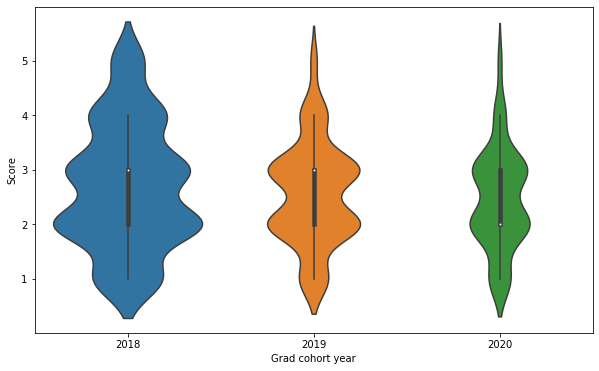

In [20]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Grad cohort year', y='Score', data=scores, scale='count');

In the below breakout by grad year, we can see that NSA-HS had the highest average score across all grades. Juniors at UCC performed better on average than Juniors at UCHS, however Sophomores at UCHS outperformed those at UCC (in terms of average score).

NSA-HS and UCHS seem to have a consistent average score across all grade levels, while UCC Juniors appear to outperform Sophomores.

<Figure size 1152x864 with 0 Axes>

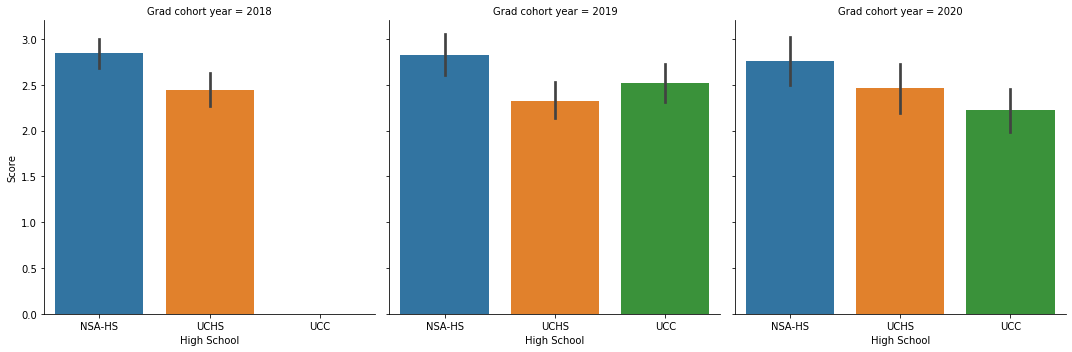

In [21]:
plt.figure(figsize=(16,12))
sns.catplot(x='High School', y='Score', col='Grad cohort year', data=scores, kind='bar');

The below stacked bar chart shows the counts of test takers who passed vs those who did not pass at each school, frpl designation, gender, and ethnicity. 

It is clear that NSA-HS had the most test takes, while UCC had the least. NSA-HS had the highest pass rate (around 60%) while UCHS fell around 40%.

Non-FRPL students had a slightly higher (~3.2%) pass rate.

There were significantly more female students taking AP tests, however they had a slightly lower pass rate than their male counterparts.

The Asian students who took AP tests were significantly fewer than the Hispanic and Black test takers, however they saw pass rates above 80% while Hispanic and Black student cohorts passed at similar rates near 50%.

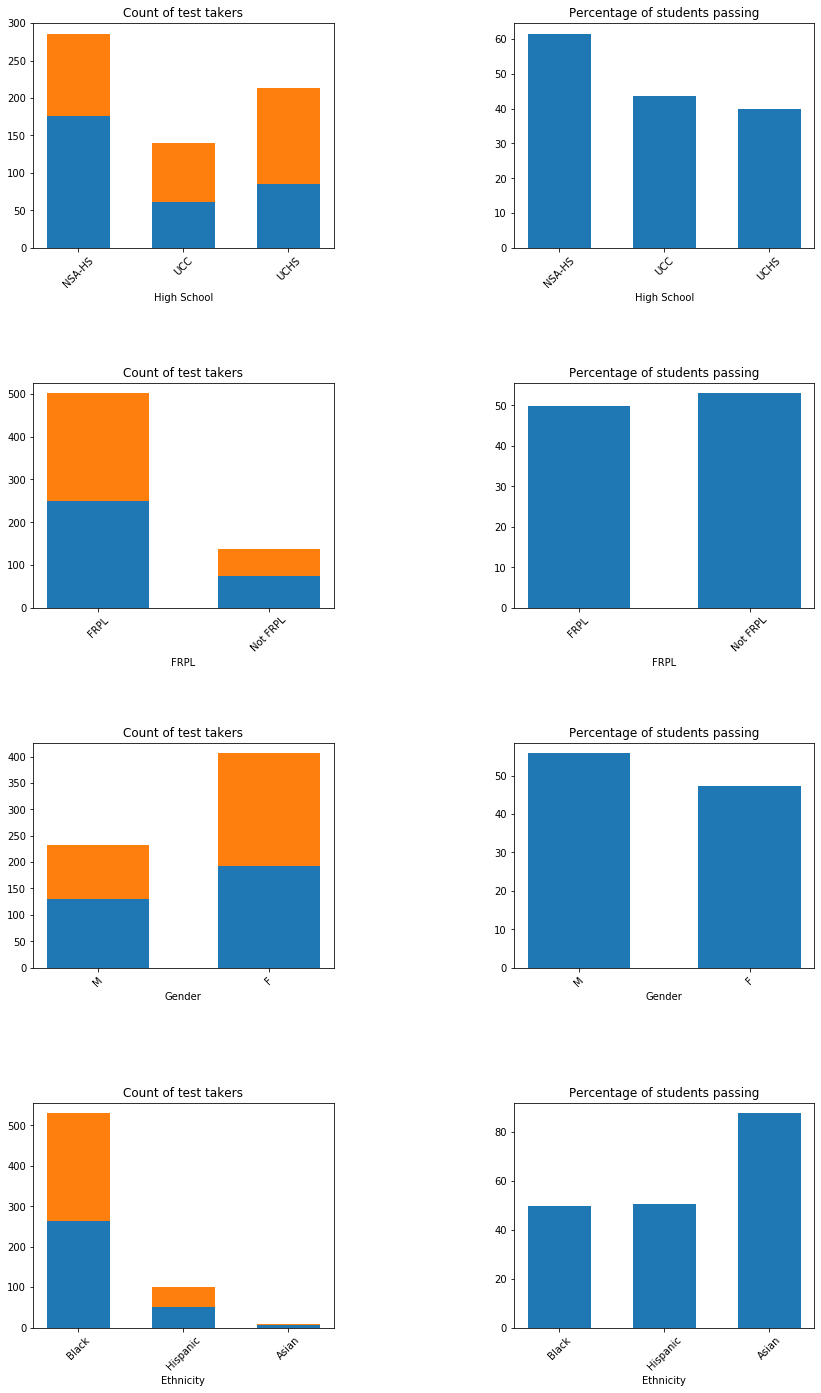

In [22]:
fig, axs = plt.subplots(4,2, figsize = (14,24))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

schools = list(set(scores['High School']))
frpl = list(set(scores['FRPL']))
gender = list(set(scores['Gender']))
ethnicity = list(set(scores['Ethnicity']))

metrics = {'High School': schools, 'FRPL': frpl, 'Gender': gender, 
           'Ethnicity': ethnicity}

a = 0

for i, j in enumerate(metrics.keys()):
    passing = []
    notpassing = []
    y = {}
    z = metrics[j]
    for k in z:
        x = scores[scores[j] == k]
        passing.append(len(x[x['Passing'] == 'Passing']))
        notpassing.append(len(x[x['Passing'] == 'Did not pass']))
        
    y[j] = z
    y['passing'] = passing
    y['notpassing'] = notpassing
    
    N = len(passing)
    ind = np.arange(N)
    ticks = list(range(N))

    df = pd.DataFrame.from_dict(y)
    df = df.set_index(j)

    axs[a,0].bar(ind, df['passing'], width=0.6)
    axs[a,0].bar(ind, df['notpassing'], bottom=df.passing, width=0.6)
    axs[a,0].set_title('Count of test takers')
    axs[a,0].set_xlabel(j)
    axs[a,0].set_xticks(ticks)
    axs[a,0].set_xticklabels(z, fontdict = {'rotation': 45})
    
    df['passrate'] = (df['passing'] / (df['passing'] + df['notpassing']))*100
    
    axs[a,1].bar(ind, df['passrate'], width=0.6)
    axs[a,1].set_title('Percentage of students passing')
    axs[a,1].set_xlabel(j)
    axs[a,1].set_xticks(ticks)
    axs[a,1].set_xticklabels(z, fontdict = {'rotation': 45})
    a += 1

Taking a quick look at subjects, we can see that World and US History are the courses with the highest participation rates, with STEM courses having the lowest participation rates.

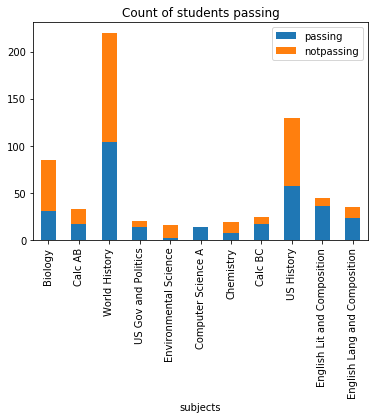

In [23]:
subjects = list(set(scores['Subject']))
passing = []
notpassing = []
y = {}
for i in subjects:
    x = scores[scores['Subject'] == i]
    passing.append(len(x[x['Passing'] == 'Passing']))
    notpassing.append(len(x[x['Passing'] == 'Did not pass']))

y['subjects'] = subjects
y['passing'] = passing
y['notpassing'] = notpassing

df = pd.DataFrame.from_dict(y)
df = df.set_index('subjects')

df.plot(kind='bar',stacked=True)
plt.title('Count of students passing')
plt.show();

Inspecting the passing rates, we see that Computer Science had a whopping 100% pass rate! There is a trend that the courses with lower participation rates tend to have higher passing rates, with the exception of Environmental Science.

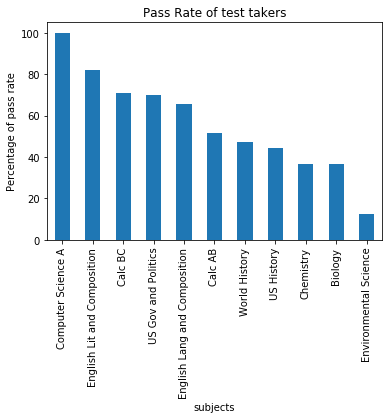

In [24]:
df['passrate'] = (df['passing'] / (df['passing'] + df['notpassing']))*100
df = df.sort_values('passrate', ascending=False)

df['passrate'].plot(kind='bar')
plt.title('Pass Rate of test takers')
plt.ylabel('Percentage of pass rate')
plt.show();